In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.io
import os

from sklearn.neighbors import KernelDensity

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)# plt.style.use('fast')

plt.rcParams.update({
    'font.size': 14,
})

In [55]:
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/jags')
path_vba = os.path.join(path_out, 'vba')
path_jags_output = os.path.join(path_out, 'jags_output')

path_pmp = os.path.join(path_vba, 'pmp_HLM_sequential_split.mat')
path_h_pdci = os.path.join(path_jags_output, 'H_pdci.mat')

# Load posterior samples for hierarchical model with PDCI submodel
mat = scipy.io.loadmat(path_h_pdci, variable_names=['samples', 'nSamples', 'nChains'], squeeze_me=True)
samples = mat['samples']

n_samples, n_chains = mat['nSamples'], mat['nChains']
n_subjects, n_conditions = 32, 2
n_prederrsign = 2
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]

# Load samples for relevant behavioral parameters
alpha_pdci = samples['alpha_pdci'].item()
beta_pdci = samples['beta_pdci'].item()
alpha_pdci = np.reshape(alpha_pdci, (n_chains * n_samples, n_subjects, n_prederrsign))
beta_pdci = np.reshape(beta_pdci, (n_chains * n_samples, n_subjects))

### Simple posterior examination



In [67]:
bf_plus_minus = np.sum(alpha_pdci[:, :, 0].flatten() > alpha_pdci[:, :, 1].flatten()) / \
                np.sum(alpha_pdci[:, :, 0].flatten() < alpha_pdci[:, :, 1].flatten())



110683

### Point parameter estimation
Estimate learning rate values as point estimates of posterior probability distribution. First, MCMC samples are converted into continuous function using kernel density estimation (KDE) with Gaussian kernel. Then, argument maximizing estimated distribution is considered as point estimate of $\alpha$. Paramater `n_gridpoints` control the grid sparsity over parameter space (i.e. gridpoints for which KDE distribution is estimated). Smoothing of KDE distribution is adjusted by `kernel_width` parameter.

In [73]:
n_gridpoints = 1001
kernel_width = 0.01
gridpoints = np.linspace(0, 1, n_gridpoints)

alpha_pdci_mle = np.zeros((n_subjects, 2))
beta_pdci_mle = np.zeros((n_subjects, 1))

for sub in range(n_subjects):
    # Calculate parameters as maximum likelihood
    kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')
    
    # Learning rates
    for j in range(n_prederrsign):
        kde.fit(alpha_pdci[:, sub, j].flatten()[:, np.newaxis])
        alpha_pdci_mle[sub, j] = gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]
    
    # Precision
    kde.fit(beta_pdci[:, sub].reshape((n_samples * n_chains, 1)))
    beta_pdci_mle[sub] = gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]

In [74]:
beta_pdci_mle

array([[0.155],
       [0.161],
       [0.176],
       [0.079],
       [0.121],
       [0.122],
       [0.061],
       [0.116],
       [0.171],
       [0.14 ],
       [0.125],
       [0.122],
       [0.08 ],
       [0.061],
       [0.134],
       [0.074],
       [0.073],
       [0.156],
       [0.145],
       [0.142],
       [0.159],
       [0.061],
       [0.141],
       [0.154],
       [0.125],
       [0.213],
       [0.083],
       [0.144],
       [0.077],
       [0.102],
       [0.139],
       [0.127]])

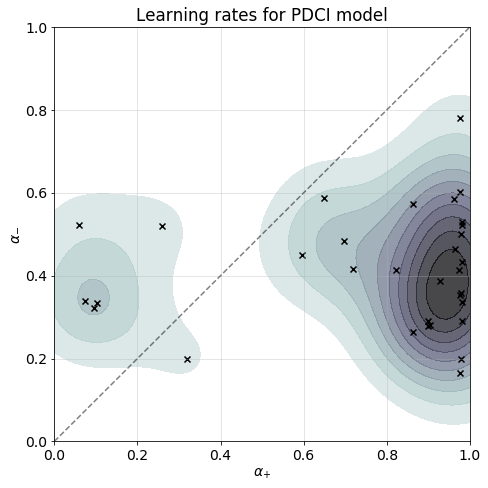

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(7, 7))

ax.plot([0, 1], [0, 1], 'k--', alpha=.5)
sns.kdeplot(
    alpha_pdci_mle[:, 0],
    alpha_pdci_mle[:, 1],
    cmap="bone_r", 
    shade=True, 
    shade_lowest=False, 
    ax=ax,
    alpha=.75,
    bw=.1
)
ax.scatter(
    alpha_pdci_mle[:, 0], 
    alpha_pdci_mle[:, 1],
    color='black', 
    marker='x'
)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=.4)
ax.set_title('Learning rates for PDCI model')
ax.set_xlabel(r'$\alpha_{+}$')
ax.set_ylabel(r'$\alpha_{-}$')

plt.tight_layout()

In [13]:
# Save point estimates to file
np.save('data/subjects_point_estimates/alpha_pdci_mle', alpha_pdci_mle)